In [3]:
import numpy as np
import time
from ekpy import control
from ekpy.control.instruments import keysight81150a, keysightdsox3024a
from scipy import interpolate
import scipy.integrate as it
import pandas as pd
import matplotlib.pyplot as plt

HERE WE ARE GOING TO CHANGE THINGS UP AND HAVE TWO OUTPUTS OF THE WAVEGEN AND THEN PUT CHNNL 

In [4]:
def pv_hysteresis_wf(initial_delay, freq, pulse_delay, voltage, qtimepoints=12):
	'''
	Modified from my original one to only return my time_arr thats been interpolated using good commands
	ayo this already interps the voltage array??? 
	'''
	#first build Qtime
	initial_delay = float(initial_delay)
	freq = float(freq)
	pulse_delay = float(pulse_delay)
	voltage = float(voltage)
	q_time = []
	t_increment = 0.0005/freq
	sumsofar = initial_delay
	q_time.append(sumsofar)
	count = 0
	for i in range(qtimepoints - 1):
		if count == 2:
			count = 0
			value = sumsofar + pulse_delay
		else:
			value = sumsofar + t_increment
			count += 1
		q_time.append(value)
		sumsofar = value
	#Now we build the time_array
	time_array = []
	time_array.append(0)
	time_array.append(initial_delay)
	t_increment2 = 0.00025/freq
	for i in range(4):
		sumsofar2 = 0
		last_element = time_array[-1]
		sumsofar2 = t_increment2 + last_element
		time_array.append(sumsofar2)
		sumsofar2 += t_increment
		time_array.append(sumsofar2)
		sumsofar2 += t_increment2
		time_array.append(sumsofar2)
		sumsofar2 += pulse_delay
		time_array.append(sumsofar2)
	
	#Now we calculate the Waveform frequency
	waveform_freq = 1/time_array[-1]
	#Now we calculate the interpolated time [This is a dumb method probably way easier way to do it]
	interp_time = []
	interp_time.append(0)
	iteration_count = 10000 - 1
	for i in range(iteration_count):
		interp_time.append((i + 1) * (time_array[-1]/iteration_count))
	#note this was the same shit as doing like np.linearinterpolate or linspace with max being the last element

	#Now we make a voltage array
	voltage_array = voltage*np.array([0,0,1,-1,0,0,1,-1,0,0,-1,1,0,0,-1,1,0,0]) 
	temp = interpolate.interp1d(time_array, voltage_array)
	interp_voltage_array = temp(interp_time)
	#only thing we use from this is interp_voltage_array wtf
	return q_time, time_array, waveform_freq, interp_time, interp_voltage_array


def setup_scope(scope, time_scale, voltage_channel, current_channel,
				voltage_scale, current_scale):
    keysightdsox3024a.initialize(scope)
    keysightdsox3024a.configure_timebase(scope, time_base_type='MAIN', reference='CENTer', scale=f'{time_scale}', position=f'{5*time_scale}')
    keysightdsox3024a.configure_channel(scope, channel=voltage_channel, vertical_scale=voltage_scale, impedance='FIFT')#set both to 50ohm
    keysightdsox3024a.configure_channel(scope, channel=current_channel, vertical_scale=voltage_scale, impedance='FIFT')
    #NOTE changing the position now to 5* the timebase to hopefully get the full signal
    keysightdsox3024a.configure_trigger_characteristics(scope, trigger_source='EXT', low_voltage_level='0.75', high_voltage_level='0.95', sweep='NORM')
    keysightdsox3024a.configure_trigger_edge(scope, trigger_source='EXT', input_coupling='DC')

	

def setup_wavegen(wavegen, voltage_channel, interp_voltage_array, waveform_freq, voltage):
    keysight81150a.initialize(wavegen)
    keysight81150a.configure_impedance(wavegen, voltage_channel, source_impedance='50.0', load_impedance='50')
    keysight81150a.configure_impedance(wavegen, '2', source_impedance='50.0', load_impedance='50') #changed load from 1000000
    keysight81150a.configure_trigger(wavegen, voltage_channel, source='MAN')
    keysight81150a.configure_output_amplifier(wavegen, voltage_channel)
    keysight81150a.configure_output_amplifier(wavegen, '2')
    keysight81150a.create_arb_wf(wavegen, interp_voltage_array, 'PV')
    keysight81150a.configure_arb_wf(wavegen, voltage_channel, 'PV', gain=f'{voltage*2}', freq=f'{waveform_freq}') #change to 10k waveform_freq
    keysight81150a.configure_arb_wf(wavegen, '2', 'PV', gain=f'{voltage*2}', freq=f'{waveform_freq}')
	


def find_index(some_array, some_value):
	'''
	Helper Function to return both the array index and the value associated with that index
	'''
	diff_array = np.abs(some_array - some_value)
	index_of_closest_value = np.argmin(diff_array)
	closest_value = some_array[index_of_closest_value]
	return index_of_closest_value, closest_value

def max_min_div2(arr):
	"""
	Helper function to simply do (max + min) /2 of an array
	"""
	return (np.max(arr) + np.min(arr))/2


'''
HERE I WILL INPUT ALL THE VARIABLE VALUES
'''
capacitor_area = '4e-8' #4e-8
permittivity = '30'
thickness = '5e-9'
amplification = '8'
initial_delay = '5e-5'
pulse_delay = '5e-5' #changed from 5e-6
freq = '10'
v_end = '3'
voltage_channel = '1'
current_channel = '2'
loop_count = '1'

rm = control.ResourceManager()

scope = rm.open_resource('USB0::0x0957::0x17A6::MY63080078::INSTR')
wavegen = rm.open_resource('GPIB0::8::INSTR')

capacitance = float(capacitor_area)*float(permittivity)*8.854e-12/float(thickness)
current_chnnl_resolution = capacitance*50*float(amplification)
if current_chnnl_resolution < 0.008: #changed from 0.008
    current_chnnl_resolution = 0.008
time_scale = (float(initial_delay) + (float(pulse_delay) * 4) + (16 * (1/(float(freq) * 4000)))) / 10
voltage_channel_scale = float(v_end)/4
#make sure that current scale >= 0.008
setup_scope(scope, time_scale, voltage_channel, current_channel, f'{voltage_channel_scale}', f'{current_chnnl_resolution}')
#Loop over the loop count
voltage_step = float(v_end)/int(loop_count)
for i in range(int(loop_count)):
    voltage = (i+1)*voltage_step
    #first we need to setup the wavegen
    q_time_arr, time_array, waveform_freq, interp_time_arr, interp_voltage_array = pv_hysteresis_wf(initial_delay, freq, pulse_delay, voltage)
    voltage_array = [0,0,1,-1,0,0,1,-1,0,0,-1,1,0,0,-1,1,0,0]
    temp = interpolate.interp1d(time_array, voltage_array)
    interp_voltage_array = temp(interp_time_arr)
    '''
    The existance of this TEMP code should really go into the pv_hysteresis_wf which I will do once the program actually works
	'''
    setup_wavegen(wavegen, voltage_channel, interp_voltage_array, waveform_freq, voltage)
    total_time = 0.004/float(freq) + (float(pulse_delay) * 4) + float(initial_delay)
	#NOW we actually take the data, send out the pulse and get the data, f labview for this part
	#Now we need to enable the wavegen, then acquire the data
    keysightdsox3024a.initiate(scope)
    keysight81150a.enable_output(wavegen)
    keysight81150a.enable_output(wavegen, '2')
    keysight81150a.send_software_trigger(wavegen)
    scope.query("*OPC?")
    keysightdsox3024a.setup_wf(scope, source='CHAN1')
    metadata_v, time_v, wfm_v = keysightdsox3024a.query_wf(scope)
    time.sleep(1) #wtf this was still here
    keysightdsox3024a.setup_wf(scope, source='CHAN2')
    metadata_c, time_c, wfm_c = keysightdsox3024a.query_wf(scope)

keysight81150a.enable_output(wavegen, on=False)
keysight81150a.enable_output(wavegen, '2', on=False)

Now we can analyze the data

In [4]:
#Now we need to integrate current to get charge Q
wfm_q = it.cumulative_trapezoid(wfm_c, time_c, initial=metadata_c["x_origin"]) #not sure if this is correct, but makes sense since x_origin is t0


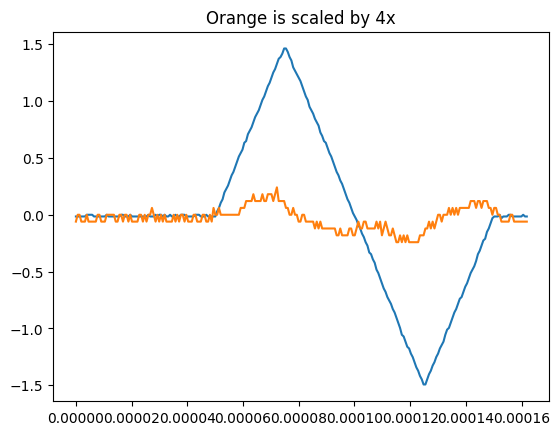

In [28]:
wfm_c_scaled = 4*np.array(wfm_c)
plt.plot(time_v[:250], wfm_v[:250])
plt.plot(time_c[:250], wfm_c_scaled[:250])
plt.title("Orange is scaled by 4x")
plt.show()

In [ ]:
#we will test a square wave and see the output

In [11]:
setup_scope(scope, time_scale, voltage_channel, current_channel, f'{voltage_channel_scale}', f'{current_chnnl_resolution}')


In [9]:
keysight81150a.set_output_wf(wavegen, '1', 'square')


In [12]:
keysight81150a.initialize(wavegen)
keysight81150a.configure_impedance(wavegen, voltage_channel, source_impedance='50.0', load_impedance='50')
keysight81150a.configure_impedance(wavegen, '2', source_impedance='50.0', load_impedance='50') #changed load from 1000000
keysight81150a.configure_trigger(wavegen, voltage_channel, source='MAN')
keysight81150a.configure_output_amplifier(wavegen, voltage_channel)
keysight81150a.configure_output_amplifier(wavegen, '2')

keysight81150a.set_output_wf(wavegen, '1', 'SQU')
keysight81150a.set_output_wf(wavegen, '2', 'SQU')
keysightdsox3024a.initiate(scope)
keysight81150a.enable_output(wavegen)
keysight81150a.enable_output(wavegen, '2')
keysight81150a.send_software_trigger(wavegen)
scope.query("*OPC?")
keysightdsox3024a.setup_wf(scope, source='CHAN1')
metadata_v, time_v, wfm_v = keysightdsox3024a.query_wf(scope)
time.sleep(1) #wtf this was still here
keysightdsox3024a.setup_wf(scope, source='CHAN2')
metadata_c, time_c, wfm_c = keysightdsox3024a.query_wf(scope)
keysight81150a.stop(wavegen)

In [14]:
wavegen.write(":FUNC{}:{}".format('1', 'SQU'))

12

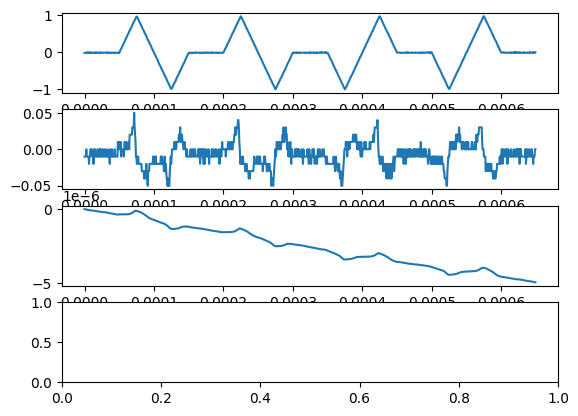

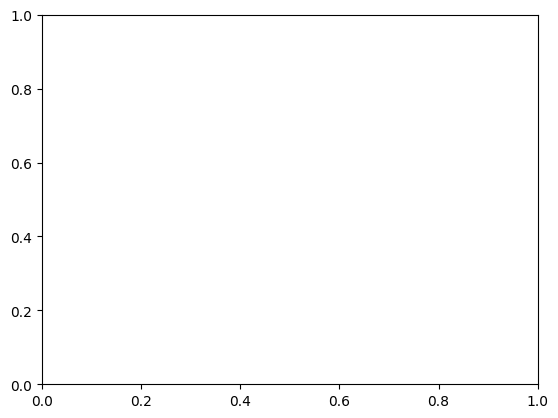

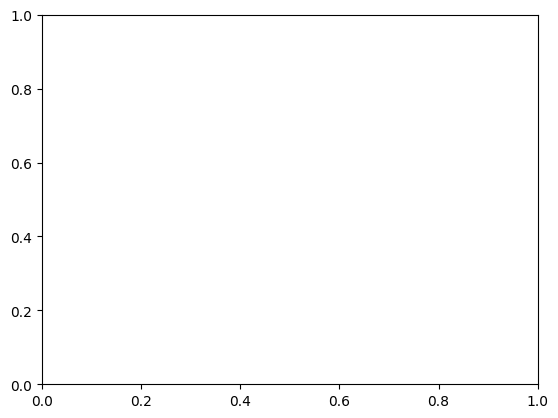

In [5]:
fig, ax = plt.subplots(4,1)

ax[0].plot(time_v, wfm_v)

ax[1].plot(time_c, wfm_c)
ax[2].plot(time_c, wfm_q)

fig2, ax2 = plt.subplots()
#just plot p1 hysteresis
fig1, ax1 = plt.subplots()


plt.show()